# Downloading dataset

In [1]:
# Download and untar data
!wget -q -O "dakshina_dataset_v1.0.tar" "https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar" 
!tar -xf dakshina_dataset_v1.0.tar
!rm dakshina_dataset_v1.0.tar

In [2]:
# The folder containing the datasets to be used in this program
!ls dakshina_dataset_v1.0/hi/lexicons
!wc -l dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv
!wc -l dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv
!wc -l dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv
!cat dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv | head

hi.translit.sampled.dev.tsv   hi.translit.sampled.train.tsv
hi.translit.sampled.test.tsv
44204 dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv
4502 dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv
4358 dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv
अं	an	3
अंकगणित	ankganit	3
अंकल	uncle	4
अंकुर	ankur	4
अंकुरण	ankuran	3
अंकुरित	ankurit	3
अंकुश	aankush	1
अंकुश	ankush	3
अंग	ang	2
अंग	anga	1
cat: write error: Broken pipe


## Imports

In [3]:
import os
import csv
import yaml
import json
import matplotlib.pyplot as plt
import numpy as np


import tensorflow as tf
import tensorflow.keras as keras
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam

import wandb
from wandb.keras import WandbCallback

from IPython.display import display
from IPython.display import HTML as html_print


# Reading and processing data

In [4]:

os.environ["WANDB_API_KEY"] = "f058e3418fb166c3bee2d5131ef0bcc4b642793f"

START_CHAR   = '\t'
END_CHAR     = '\n'
BLANK_CHAR   = ' '
ln           = 'hi'

root      = f"dakshina_dataset_v1.0/{ln}/lexicons/"
train_dir = f"dakshina_dataset_v1.0/{ln}/lexicons/{ln}.translit.sampled.train.tsv"
test_dir  = f"dakshina_dataset_v1.0/{ln}/lexicons/{ln}.translit.sampled.test.tsv"
val_dir   = f"dakshina_dataset_v1.0/{ln}/lexicons/{ln}.translit.sampled.dev.tsv"

In [5]:
def load_data_from_csv(data_path):
    """
    Function to load the data from the csv file
    input
    * data_path (string): path to the csv file

    output
    * inputs (list): word list in the input column
    * targetlist (list): word list in the target column
    """

    targets = []
    inputs = []
    with open(data_path, 'r') as file:
        for line in file:
            _target, _input = line.split("\t")[:2]
            targets.append(_target)
            inputs.append(_input)
    return inputs, targets


def encode_decode_characters(train_input, train_target, val_input, val_target):
    '''
    Returns a mapping for 
    * characters to integer (as a dictionary)
    * integers to characters (as a dictionary)
    * max_input_seq_length
    * max_target_seq_length
    for input and target data
    '''

    # mapping of input vocabulary
    input_char_to_int = {}
    input_int_to_char = []
    max_input_seq_length = 1

    for string in train_input + val_input:
        max_input_seq_length = max(max_input_seq_length, len(string))
        for char in string:
            if char not in input_char_to_int:
                input_char_to_int[char] = len(input_int_to_char)
                input_int_to_char.append(char)

    if BLANK_CHAR not in input_char_to_int:
        input_char_to_int[BLANK_CHAR] = len(input_int_to_char)
        input_int_to_char.append(BLANK_CHAR)

    # mapping of target vocabulary
    target_char_to_int = {}
    target_int_to_char = []
    target_char_to_int[START_CHAR] = len(target_int_to_char)
    target_int_to_char.append(START_CHAR)
    max_target_seq_length = 1

    for string in train_target + val_target:
        max_target_seq_length = max(max_target_seq_length, len(string)+2)
        for char in string:
            if char not in target_char_to_int:
                target_char_to_int[char] = len(target_int_to_char)
                target_int_to_char.append(char)
    target_char_to_int[END_CHAR] = len(target_int_to_char)
    target_int_to_char.append(END_CHAR)

    if BLANK_CHAR not in target_char_to_int:
        target_char_to_int[BLANK_CHAR] = len(target_int_to_char)
        target_int_to_char.append(BLANK_CHAR)

    print("Number of training samples:", len(train_input))
    print("Number of validation samples:", len(val_input))
    print("Number of unique input chars:", len(input_int_to_char))
    print("Number of unique output chars:", len(target_int_to_char))
    print("Max sequence length for inputs:", max_input_seq_length)
    print("Max sequence length for outputs:", max_target_seq_length)

    return input_char_to_int, input_int_to_char, target_char_to_int, target_int_to_char, max_input_seq_length, max_target_seq_length


def process_data(inputs, max_input_seq_length, input_char_to_int, targets=None, max_target_seq_length=None, target_char_to_int=None):
    '''
    Returns the input and target data in a form needed by the Keras embedding layer 

    * encoder_input & decoder_input: (None, timesteps) where each character is encoded by an integer
    * decoder_output: (None, timesteps, vocabulary_size) where the last dimension is the one-hot encoding of the target character

    Inputs
    * train_ip (list): list of strings
    * max_input_seq_length (int): maximum length of input sequence
    * input_char_to_int (dict): mapping of input characters to integers
    * train_out (list): list of strings
    * max_target_seq_length (int): maximum length of target sequence
    * target_char_to_int (dict): mapping of target characters to integers
    '''

    encoder_inputs = []

    for s in inputs:
        temp = [input_char_to_int[c] for c in s] + \
            [input_char_to_int[BLANK_CHAR]] * (max_input_seq_length-len(s))
        encoder_inputs.append(temp)

    encoder_inputs = np.array(encoder_inputs)

    decoder_inputs = []

    for s in targets:
        temp = [target_char_to_int[START_CHAR]] + [target_char_to_int[c]
                                                   for c in s] + [target_char_to_int[END_CHAR]]
        temp += [target_char_to_int[BLANK_CHAR]] * \
            (max_target_seq_length - len(s) - 2)
        decoder_inputs.append(temp)

    decoder_inputs = np.array(decoder_inputs)

    # one-hot encoding of the target character for decoder_target
    decoder_targets = np.zeros(
        (len(targets), max_target_seq_length, len(target_char_to_int)), dtype='float32')

    for i in range(decoder_inputs.shape[0]):
        for t, char_index in enumerate(decoder_inputs[i]):
            if t > 0:
                decoder_targets[i, t-1, char_index] = 1.0
        decoder_targets[i, t:, target_char_to_int[BLANK_CHAR]] = 1.0

    return encoder_inputs, decoder_inputs, decoder_targets


In [6]:

input_char_to_int        = {}
input_int_to_char        = []
target_char_to_int       = {}
target_int_to_char       = []
max_input_seq_length     = 0
max_target_seq_length    = 0


# Reading training, validation and test data
train_in, train_out  = load_data_from_csv(train_dir)
val_in, val_out      = load_data_from_csv(val_dir)
test_in, test_out    = load_data_from_csv(test_dir)


# Assigning encoding and decoding for input and target characters
input_char_to_int, input_int_to_char, target_char_to_int, target_int_to_char, max_input_seq_length, max_target_seq_length = encode_decode_characters(
    train_in, train_out, val_in, val_out)


# Assigning training, validation and test encoder input, decoder input, decoder output
train_enc_input, train_dec_input, train_dec_target  = process_data(train_in, max_input_seq_length, input_char_to_int,
                                                                  train_out, max_target_seq_length, target_char_to_int)
val_enc_input, val_dec_input, val_dec_target        = process_data(val_in, max_input_seq_length, input_char_to_int,
                                                            val_out, max_target_seq_length, target_char_to_int)
test_enc_input, test_dec_input, test_dec_target     = process_data(test_in, max_input_seq_length, input_char_to_int,
                                                               test_out, max_target_seq_length, target_char_to_int)


Number of training samples: 44204
Number of validation samples: 4358
Number of unique input chars: 27
Number of unique output chars: 66
Max sequence length for inputs: 20
Max sequence length for outputs: 21


# Seq2Seq Model (without Attention - Vanilla)

### Creating model (without attention)

In [7]:
def create_model(
    input_vocab_size,
    target_vocab_size,
    input_embedding_size=64,
    num_encoder_layers=1,
    num_decoder_layers=1,
    hidden_layer_size=64,
    cell_type='LSTM',
    dropout=0,
    r_dropout=0,
    cell_activation='tanh'
):
    '''
    Function to create a seq2seq model without attention.

    inputs
    * input_vocab_size: (int) number of characters in input vocabulary
    * target_vocab_size: (int) number of characters in output vocabulary
    * input_embedding_size: (int, default : 64) size of input embedding layer for encoder and decoder
    * num_encoder_layers: (int, default : 1) number of layers of cell to stack in encoder
    * num_decoder_layers: (int, default : 1) number of layers of cell to stack in decoder
    * hidden_layer_size: (int, default : 64) size of hidden layer of the encoder and decoder cells
    * cell_type: (string, default : 'LSTM') type of cell used in encoder and decoder (possible values : 'LSTM', 'GRU', 'RNN')
    * dropout: (float, default : 0.0) value of normal dropout (between 0 and 1)
    * r_dropout: (float, default : 0.0) value of recurrent dropout (between 0 and 1)
    * cell_activation: (string, default : 'tanh') type of activation used in the cell (as required by Keras)

    Returns
    * model: (Keras model object) resulting non-attention model
    '''

    get_cell = {
        'RNN': keras.layers.SimpleRNN,
        'GRU': keras.layers.GRU,
        'LSTM': keras.layers.LSTM
    }

    # Encoder input and embedding
    encoder_input = keras.layers.Input(shape=(None,), name="input_1")
    encoder_inp_emb = keras.layers.Embedding(
        input_vocab_size, input_embedding_size, name="embedding_1")(encoder_input)

    # Encoder cell layers
    encoder_seq, *encoder_state = get_cell[cell_type](hidden_layer_size,
                                                      activation=cell_activation,
                                                      return_sequences=True,
                                                      return_state=True,
                                                      dropout=dropout,
                                                      recurrent_dropout=r_dropout,
                                                      name="encoder_1"
                                                      )(encoder_inp_emb)
    for i in range(1, num_encoder_layers):
        encoder_seq, *encoder_state = get_cell[cell_type](hidden_layer_size,
                                                          activation=cell_activation,
                                                          return_sequences=True,
                                                          return_state=True,
                                                          dropout=dropout,
                                                          recurrent_dropout=r_dropout,
                                                          name="encoder_" +
                                                          str(i+1)
                                                          )(encoder_seq)

    # Decoder input and embedding
    decoder_input = keras.layers.Input(shape=(None,), name="input_2")
    decoder_inp_emb = keras.layers.Embedding(
        target_vocab_size, input_embedding_size, name="embedding_2")(decoder_input)

    # Decoder cell layers
    decoder_seq, *_ = get_cell[cell_type](hidden_layer_size,
                                          activation=cell_activation,
                                          return_sequences=True,
                                          return_state=True,
                                          dropout=dropout,
                                          recurrent_dropout=r_dropout,
                                          name="decoder_1"
                                          )(decoder_inp_emb, initial_state=encoder_state)

    for i in range(1, num_decoder_layers):
        decoder_seq, *_ = get_cell[cell_type](hidden_layer_size,
                                              activation=cell_activation,
                                              return_sequences=True,
                                              return_state=True,
                                              dropout=dropout,
                                              recurrent_dropout=r_dropout,
                                              name="decoder_"+str(i+1)
                                              )(decoder_seq, initial_state=encoder_state)

    # Softmax FC layer
    decoder_dense_output = keras.layers.Dense(
        target_vocab_size, activation="softmax", name="dense_1")(decoder_seq)

    model = keras.Model([encoder_input, decoder_input], decoder_dense_output)
    model.summary(line_length=150)
    return model


# Logging into W&B

In [8]:
!wandb login f058e3418fb166c3bee2d5131ef0bcc4b642793f

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Inference Model (without attention)

In [9]:
def create_inference_model(model):
    '''
    Function to return models needed for inference from the original model.

    Inputs
    * model (Keras model object): non-attention model used for training

    Returns 
    * encoder_model (Keras model object): encoder model 
    * deocder_model (Keras model object): decoder model
    * no_enc_layers (int): number of layers in the encoder
    * no_dec_layers (int): number of layers in the decoder
    '''

    # Count the number of layers in encoder and decoder
    no_enc_layers, no_dec_layers = 0, 0
    for layer in model.layers:
        no_enc_layers += layer.name.startswith('encoder')
        no_dec_layers += layer.name.startswith('decoder')

    # Encoder input
    encoder_input = model.input[0]      # Input_1
    # Encoder cell final layer
    encoder_cell = model.get_layer("encoder_"+str(no_enc_layers))
    encoder_type = encoder_cell.__class__.__name__
    encoder_seq, *encoder_state = encoder_cell.output
    # Encoder model
    encoder_model = keras.Model(encoder_input, encoder_state)

    # Decoder input
    decoder_input = model.input[1]      # Input_2
    decoder_inp_emb = model.get_layer("embedding_2")(decoder_input)
    decoder_seq = decoder_inp_emb
    # Inputs to decoder layers' initial states
    decoder_states, decoder_state_inputs = [], []
    for i in range(1, no_dec_layers+1):
        if encoder_type == 'LSTM':
            decoder_state_input = [keras.Input(shape=(encoder_state[0].shape[1],), name="input_"+str(2*i+1)),
                                   keras.Input(shape=(encoder_state[1].shape[1],), name="input_"+str(2*i+2))]
        else:
            decoder_state_input = [keras.Input(
                shape=(encoder_state[0].shape[1],), name="input_"+str(i+2))]

        decoder_cell = model.get_layer("decoder_"+str(i))
        decoder_seq, * \
            decoder_state = decoder_cell(
                decoder_seq, initial_state=decoder_state_input)
        decoder_states += decoder_state
        decoder_state_inputs += decoder_state_input

    # Softmax FC layer
    decoder_dense = model.get_layer("dense_1")
    decoder_dense_output = decoder_dense(decoder_seq)

    # Decoder model
    decoder_model = keras.Model(
        [decoder_input] + decoder_state_inputs, [decoder_dense_output] + decoder_states
    )

    return encoder_model, decoder_model, no_enc_layers, no_dec_layers


def convert_to_word(predictions, char_enc, char_dec=None):
    # Function to return the predictions after cutting the END_CHAR and BLANK_CHAR s at the end.
    # If char_dec == None, the predictions are in the form of decoded string, otherwise as list of integers
    no_samples = len(predictions) if type(
        predictions) is list else predictions.shape[0]
    pred_words = ['' for _ in range(no_samples)]
    for i, pred_list in enumerate(predictions):
        for l in pred_list:
            # Stop word : END_CHAR
            if l == char_enc[END_CHAR]:
                break
            pred_words[i] += char_dec[l] if char_dec is not None else l

    return pred_words

### Beam decoder (with/without attention) for inference

In [10]:

def beam_decoder_infer(model, input_seqs, max_decoder_timesteps, K=1, target_seqs=None, starting_char_enc=0, batch_size=64, attention=False):
    '''
    Function to do inference on the model using beam decoder.
    Arguments :
        model -- (Keras model object) training model
        input_seqs -- (numpy ndarray of size : (None, timesteps)) input to encoder
        max_decoder_timesteps -- (int) Number of timesteps to infer in decoder
        K -- (int, default : 1) beam width of beam decoder
        target_seqs -- (numpy ndarray of size : (None, timesteps, decoder_vocab_size), deault : None) expected target.
                       If None, cross entropy errors won't be calculated.
        starting_char_enc -- (int, default : 0) Encoding integer for START_CHAR
        batch_size -- (int, default : 64) batch_size sent to Keras predict
        attention -- (bool, defualt : False) whether the model has attention or not
    Returns :
        final_outputs -- (numpy ndarray of size : (None, K, timesteps)) top K output sequences
        final_errors -- (numpy ndarray of size : (None, K)) cross entropy errors for top K output (All zeros if target_seqs == None)
        states_values -- (numpy ndarray of size : (K, None, timesteps, hid_layer_size))  hidden states of decoder
        final_attn_scores -- (numpy ndarray of size : (None, K, decoder_timesteps, encoder_timesteps)) attention to all encoder timesteps for a decoder timestep 
    '''
    # Generating output from encoder
    encoder_model, decoder_model, no_enc_layers, no_dec_layers = create_attention_inference_model(
        model) if attention else create_inference_model(model)
    encoder_output = encoder_model.predict(input_seqs, batch_size=batch_size)
    encoder_out = encoder_output if type(
        encoder_output) is list else [encoder_output]

    # Number of input samples in the data passed
    no_samples = input_seqs.shape[0]

    # Top K output sequences for each input
    final_outputs = np.zeros(
        (no_samples, K, max_decoder_timesteps), dtype=np.int32)
    # Errors for top K output sequences for each input
    final_errors = np.zeros((no_samples, K))
    # Attention scores for top K output sequences for each input
    final_attn_scores = np.zeros(
        (no_samples, K, max_decoder_timesteps, input_seqs.shape[1]))

    # decoder input sequence for 1 timestep (for all samples). Initially one choice only there
    decoder_k_inputs = np.zeros((no_samples, 1, 1))
    # Populate the input sequence with the start character at the 1st timestep
    decoder_k_inputs[:, :, 0] = starting_char_enc

    # (log(probability) sequence, decoder output sequence) pairs for all choices and all samples. Probability starts with log(1) = 0
    decoder_k_out = [[(0, [])] for _ in range(no_samples)]
    # Categorical cross entropy error in the sequence for all choice and all samples
    errors = [[0] for _ in range(no_samples)]
    # Output states from decoder for all choices, and all samples
    states_values = [encoder_out * no_dec_layers]

    # Attention weights output
    attn_k_scores = [[None] for _ in range(no_samples)]

    # Sampling loop
    for it in range(max_decoder_timesteps):
        # Storing respective data for all possibilities
        All_k_beams = [[] for _ in range(no_samples)]
        All_decoder_states = [[] for _ in range(no_samples)]
        All_errors = [[] for _ in range(no_samples)]
        All_attn_scores = [[] for _ in range(no_samples)]

        for k in range(len(decoder_k_out[0])):
            if attention:
                attn_score, decoder_output, *decoder_states = decoder_model.predict(
                    [input_seqs, decoder_k_inputs[:, k]] + states_values[k], batch_size=batch_size)
            else:
                decoder_output, *decoder_states = decoder_model.predict(
                    [decoder_k_inputs[:, k]] + states_values[k], batch_size=batch_size)

            # Top K scores
            top_k = np.argsort(decoder_output[:, -1, :], axis=-1)[:, -K:]
            for b in range(no_samples):
                All_k_beams[b] += [(
                    decoder_k_out[b][k][0] +
                    np.log(decoder_output[b, -1, top_k[b][i]]),
                    decoder_k_out[b][k][1] + [top_k[b][i]]
                ) for i in range(K)]

                if attention:
                    All_attn_scores[b] += [attn_score[b]] * K if attn_k_scores[b][k] is None else [
                        np.concatenate((attn_k_scores[b][k], attn_score[b]), axis=0)] * K

                if target_seqs is not None:
                    All_errors[b] += [errors[b][k] -
                                      np.log(decoder_output[b, -1, target_seqs[b, it]])] * K

                All_decoder_states[b] += [[state[b:b+1]
                                           for state in decoder_states]] * K

        # Sort and choose top K with max probabilities
        sorted_ind = list(range(len(All_k_beams[0])))
        sorted_ind = [sorted(sorted_ind, key=lambda ix: All_k_beams[b]
                             [ix][0])[-K:][::-1] for b in range(no_samples)]
        # Choose the top K decoder output sequences till now
        decoder_k_out = [[All_k_beams[b][ind]
                          for ind in sorted_ind[b]] for b in range(no_samples)]

        # Update the input sequence for next 1 timestep
        decoder_k_inputs = np.array(
            [[All_k_beams[b][ind][1][-1] for ind in sorted_ind[b]] for b in range(no_samples)])

        # Update states
        states_values = [All_decoder_states[0][ind] for ind in sorted_ind[0]]
        for b in range(1, no_samples):
            states_values = [[np.concatenate((states_values[i][j], All_decoder_states[b][ind][j]))
                              for j in range(len(All_decoder_states[b][ind]))] for i, ind in enumerate(sorted_ind[b])]

        # Update attention scores
        if attention:
            attn_k_scores = [[All_attn_scores[b][ind]
                              for ind in sorted_ind[b]] for b in range(no_samples)]

        # Update errors
        if target_seqs is not None:
            errors = [[All_errors[b][ind] for ind in sorted_ind[b]]
                      for b in range(no_samples)]

    final_outputs = np.array([[decoder_k_out[b][i][1]
                             for i in range(K)] for b in range(no_samples)])
    if target_seqs is not None:
        final_errors = np.array(errors) / max_decoder_timesteps
    if attention:
        final_attn_scores = np.array(attn_k_scores)

    return final_outputs, final_errors, np.array(states_values), final_attn_scores


def calc_metrics(k_outputs, target_seqs, char_enc, char_dec, k_errors=None, exact_word=True):
    # Calculates the accuracy (and mean error if info provided) for the best of K possible output sequences
    # target_seqs -- Expected output (encoded sequence)
    # k_outputs -- k choices of output sequences for each sample

    matches = np.mean(k_outputs == np.repeat(target_seqs.reshape(
        (target_seqs.shape[0], 1, target_seqs.shape[1])), k_outputs.shape[1], axis=1), axis=-1)
    best_k = np.argmax(matches, axis=-1)
    best_ind = (tuple(range(best_k.shape[0])), tuple(best_k))
    accuracy = np.mean(matches[best_ind])

    loss = None
    if k_errors is not None:
        loss = np.mean(k_errors[best_ind])
    if exact_word:
        equal = [0] * k_outputs.shape[0]
        true_out = convert_to_word(target_seqs, char_enc, char_dec)
        for k in range(k_outputs.shape[1]):
            pred_out = convert_to_word(k_outputs[:, k], char_enc, char_dec)
            equal = [equal[i] or (pred_out[i] == true_out[i])
                     for i in range(k_outputs.shape[0])]
        exact_accuracy = np.mean(equal)

        return accuracy, exact_accuracy, loss

    return accuracy, loss


def beam_decoder(model, input_seqs, target_seqs_onehot, max_decoder_timesteps, char_enc, char_dec, K=1,
                 model_batch_size=64, attention=False, infer_batch_size=512, exact_word=True, return_outputs=False,
                 return_states=False, return_attn_scores=False):
    '''
    Function to calculate/capture character-wise accuracy, exact-word-match accuracy, and loss for the seq2seq model using a beam decoder.
    Arguments :
        model -- (Keras model object) model used for training
        input_seqs -- (numpy ndarray of size : (None, timesteps)) input to encoder (where characters are encoded as integers)
        target_seqs -- (numpy ndarray of size : (None, timesteps, decoder_vocab_size)) expected target in onehot format
        max_decoder_timesteps -- (int) Number of timesteps to infer in decoder
        char_enc -- (dict) target character encoding
        char_dec -- (list) target character decoding
        K -- (int, default : 1) beam width to be used in beam decoder
        model_batch_size -- (int, default : 64) batch size to be used while evaluating model using Keras
        attention -- (bool, defualt : False) whether the model has attention or not
        infer_batch_size -- (int, default : 512) number of samples to be sent to beam_decoder_infer() at a time (to avoid RAM memory overshoot problems).
                            We have set the default model_batch_size and infer_batch_size such that it takes the least time to run and runs without problems in Google Colab.
        exact_word -- (bool, default : True) whether or not exact_accuracy has (If True, will be returned as the next argument after accuracy)
        return_outputs -- (bool, default : True) whether or not the outputs predicted need to be returned
        return_states -- (bool, default : True) whether or not the decoder hidden states need to be returned (for further training, another sequential model addition, etc)
        return_attn_scores -- (bool, default : True) whether or not the attention scores need to be returned
    Returns :
        accuracy -- (float) the character-wise match accuracy (as calculated by Keras fit)
        (If exact_word is True) exact_accuracy -- (float) the exact word match accuracy
        loss -- (float) the cross-entropy loss for the top K predictions
        (If return_outputs is True) k_outputs -- (numpy ndarray of size : (None, K, timesteps)) top K output sequences
        (If return_states is True) k_states -- (numpy ndarray of size : (K, None, timesteps, hid_layer_size))  hidden states of decoder
        (If return_attn_scores is True) k_attn_scores -- (numpy ndarray of size : (None, K, decoder_timesteps, encoder_timesteps)) attention scores
    '''
    target_seqs = np.argmax(target_seqs_onehot, axis=-1)
    k_outputs, k_errors, k_states, k_attn_scores = None, None, None, None
    for i in range(0, input_seqs.shape[0], infer_batch_size):
        tmp_k_outputs, tmp_k_errors, tmp_k_states, tmp_k_attn_scores = beam_decoder_infer(model, input_seqs[i:i+infer_batch_size],
                                                                                          max_decoder_timesteps, K,
                                                                                          target_seqs[i:i +
                                                                                                      infer_batch_size], char_enc['\t'],
                                                                                          model_batch_size, attention)
        if k_errors is None:
            k_outputs, k_errors, k_states, k_attn_scores = tmp_k_outputs, tmp_k_errors, tmp_k_states, tmp_k_attn_scores
        else:
            k_outputs = np.concatenate((k_outputs, tmp_k_outputs))
            k_errors = np.concatenate((k_errors, tmp_k_errors))
            k_states = np.concatenate((k_states, tmp_k_states), axis=2)
            k_attn_scores = np.concatenate((k_attn_scores, tmp_k_attn_scores))

    return_elements = []
    if return_outputs:
        return_elements += [k_outputs]
    if return_states:
        return_elements += [k_states]
    if return_attn_scores:
        return_elements += [k_attn_scores]

    if len(return_elements) > 0:
        return calc_metrics(k_outputs, target_seqs, char_enc, char_dec, k_errors, exact_word) + tuple(return_elements)

    return calc_metrics(k_outputs, target_seqs, char_enc, char_dec, k_errors, exact_word)



### Training (without attention)

In [11]:
class custom_validator(keras.callbacks.Callback):
    '''
    Custom class to provide callback after each epoch of training to calculate custom metrics for validation set with beam decoder
    '''

    def __init__(self, val_enc_input, val_dec_target, beam_width=1, batch_size=64, attention=False):
        self.beam_width = beam_width
        self.validation_input = val_enc_input
        self.validation_target = val_dec_target
        self.batch_size = batch_size
        self.attention = attention

    def on_epoch_end(self, epoch, logs):
        val_accuracy, val_exact_accuracy, val_loss = beam_decoder(self.model, self.validation_input, self.validation_target, max_target_seq_length,
                                                                  target_char_to_int, target_int_to_char, self.beam_width, self.batch_size, self.attention)

        # Log them to reflect in WANDB callback and EarlyStopping
        logs["val_accuracy"] = val_accuracy
        logs["val_exact_accuracy"] = val_exact_accuracy
        # Validation loss calculates categorical cross entropy loss
        logs["val_loss"] = val_loss

        print("— val_loss: {:.4f} — val_accuracy: {:.4f} — val_exact_accuracy: {:.4f}".format(
            val_loss, val_accuracy, val_exact_accuracy))


In [12]:
def train_model(
        model,
        train_input_data,
        train_target_data,
        val_input_data,
        val_target_data,
        beam_width=1,
        attention=False,
        batch_size=64,
        optimizer='adam',
        learning_rate=1e-3,
        epochs=10,
        loss_fn='categorical_crossentropy'):
    '''
    Trains the model using Keras fit() function

    Inputs
    * model (keras model) : the model to be trained
    * train_input_data    : [train_enc_input, train_dec_input], 
    * train_target_data   : train_dec_target
    * val_input_data      : [val_enc_input, val_dec_input],
    * val_target_data     : val_dec_target
    * beam_width (int, default : 1)     : beam width for beam decoder
    * batch_size (int, default : 64)    : batch size for training
    * optimizer (str, default : 'adam') : optimizer for training
    * learning_rate (float, default : 1e-3) : learning rate for training
    * epochs (int, default : 10) : number of epochs for training
    * loss_fn (str, default : 'categorical_crossentropy') : loss function for training
    '''

    get_optimizer = {
        'adam': Adam(learning_rate=learning_rate),
        'momentum': SGD(learning_rate=learning_rate, momentum=0.9),
        'rmsprop': RMSprop(learning_rate=learning_rate),
        'nesterov': SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
        'nadam': Nadam(learning_rate=learning_rate),
    }


    model.compile(
        optimizer=get_optimizer[optimizer], loss=loss_fn, metrics=['accuracy'])

    model.fit(train_input_data,
              train_target_data,
              batch_size=batch_size,
              epochs=epochs,
              verbose=2,
              callbacks=[
                  custom_validator(
                      val_input_data[0],
                      val_target_data,
                      beam_width,
                      batch_size,
                      attention
                  ),
                  WandbCallback(monitor='val_accuracy'),
                  EarlyStopping(monitor='val_accuracy', patience=5)
              ]
              )

    return model


In [13]:
model_config = {
    "epochs": 1,
    "batch_size": 64,

    "optimizer": 'adam',
    "learning_rate": 1e-3,

    "cell_type": 'GRU',
    "num_enc_layers": 3,
    "input_emb_size": 256,
    "num_dec_layers": 3,
    "hidden_layer_size": 256,

    "dropout": 0.25,
    "beam_width": 5,
    "attention": False
}


def get_or_load_model_wo_att(config, load_model=None, wandb_init=True):
    '''
    Function to load/create a model (without attention) and train it.

    Inputs
    * config (dict) : model configurations hyperparameters. if load_model is not None, this isn't necessary.
    * load_model (string, default : None) : WANDB run ID of the model to train further. The configurations will be read from WANDB as well.
    * wandb_init (bool, default : True) : whther or not WANDB run needs to be initiated

    Returns
    * model (Keras model object) : trained model
    * config (dict) : configuration dictionary
    * id (string) : WANDB run ID used for training the model
    '''

    # If load_model is not None, load the model from WANDB
    if load_model is not None:
        run = wandb.Api().run('ms20/A3/'+load_model)
        model_h5 = run.file('model-best.h5').download(replace=True)
        model = keras.models.load_model(model_h5.name)
        config_file = run.file('config.yaml').download(replace=True)

        with open(config_file.name, 'r') as file:
            config_tmp = yaml.safe_load(file)

        config_keys = ['learning_rate', 'epochs', 'optimizer', 'batch_size', 'input_emb_size',
                       'num_enc_layers', 'num_dec_layers', 'hidden_layer_size', 'dropout', 'cell_type', 'beam_width']

        config = {}
        config['attention'] = False

        for key in config_keys:
            config[key] = config_tmp[key]['value']

    # If load_model is None, create a new model
    else:
        model = create_model(
            input_vocab_size=len(input_int_to_char),
            target_vocab_size=len(target_int_to_char),
            input_embedding_size=config['input_emb_size'],
            num_encoder_layers=config['num_enc_layers'],
            num_decoder_layers=config['num_dec_layers'],
            hidden_layer_size=config['hidden_layer_size'],
            cell_type=config['cell_type'],
            dropout=config['dropout'],
            r_dropout=config['dropout'],
            cell_activation='tanh',
        )

    id = None
    if wandb_init:
        id = wandb.util.generate_id()
        run = wandb.init(id=id, project="A3", reinit=True, config=config)

        name = f"{config['cell_type']}_es_{config['input_emb_size']}_ne_{config['num_enc_layers']}"\
            f"_nd_{config['num_dec_layers']}_hls_{config['hidden_layer_size']}_opt_{config['optimizer']}"\
            f"_lr_{config['learning_rate']}_bw_{config['beam_width']}_att_{config['attention']}"

        wandb.run.name = name
        wandb.run.save()


    model = train_model(
        model,
        [train_enc_input, train_dec_input],
        train_dec_target,
        [val_enc_input, val_dec_input],
        val_dec_target,
        config['beam_width'],
        config['attention'],
        config['batch_size'],
        config['optimizer'],
        config['learning_rate'],
        config['epochs'],
    )

    if wandb_init:
        run.finish()

    return model, config, id

### Sweep (models without attention)

In [14]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass


def sweep_wrapper():
    # Initialize a new wandb run
    run = wandb.init(config=model_config, reinit=True)
    config = wandb.config

    name = f"{config.cell_type}_es_{config.input_emb_size}_ne_{config.num_enc_layers}"\
        f"_nd_{config.num_dec_layers}_hls_{config.hidden_layer_size}_opt_{config.optimizer}"\
        f"_lr_{config.learning_rate}_bw_{config.beam_width}_att_{config.attention}"

    # wandb.run.name = f'ie_{config.inp_emb_size}_ne_{config.no_enc_layers}_de_{config.no_dec_layers}_ct_{config.cell_type}_dr_{config.dropout}'
    # wandb.run.name += f'_da_{config.hid_layer_size}_K_{config.beam_width}'

    wandb.run.name = name
    wandb.run.save()
    # print(wandb.run.name)

    model, *_ = get_or_load_model_wo_att(config, wandb_init=False)
    run.finish()



In [15]:
# Sweep configurations
sweep_config = {
    'name': 'sweep_w/o_attention',
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'input_emb_size': {
            'values': [32, 64, 256]
        },
        'num_enc_layers': {
            'values': [1, 2, 3]
        },
        'num_dec_layers': {
            'values': [1, 2, 3]
        },
        'hidden_layer_size': {
            'values': [32, 64, 256]
        },
        'cell_type': {
            'values': ['RNN', 'LSTM', 'GRU']
        },
        'dropout': {
            'values': [0, 0.1, 0.2, 0.4]
        },
        'beam_width': {
            'values': [3, 5]
        }
    }
}


# sweep_id = wandb.sweep(sweep_config, project="A3", entity="ms20")
# wandb.agent(sweep_id, sweep_wrapper, count=1)

### Test accuracy and sample input/output for best model (without attention)

In [16]:
def levenshtein(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(
                    1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [17]:
def test_model(
    run_id,
    test_enc_input,
    test_dec_target,
    max_decoder_seq_length,
    target_char_enc,
    target_char_dec,
    attention=False,
    save_pred=False,
    test_input=None
):
    '''
    Function to evaluate the model metrics on test data and save the predictions.

    Input 
    * run_id (string) WANDB run ID for the trained model
    * test_enc_input (numpy ndarray of size : (None, timesteps)) input to encoder (where characters are encoded as integers)
    * test_dec_target (numpy ndarray of size : (None, timesteps, decoder_vocab_size)) expected target in onehot format
    * max_decoder_seq_length (int) number of timesteps in the decoder
    * target_enc_enc (dict) target character encoding
    * target_char_dec (list) target character decoding
    * attention (bool, default : False) whether or not the model uses attention
    * save_pred (bool, default : False) whether or not to save the predictions in a csv file
    * test_input (list of string : (no_samples, input word), default : None) input as words (needed while saving predictions to file alone)

    Returns
    * acc (float) character-wise match accuracy
    * exact_K_acc (float) exact word match accuracy using the beam width for the model
    * exact_acc (float) exact word match accuracy using the first prediction (which is equivalent to beam width = 1)
    * loss (float) loss value
    * true_out (list of string : (no_samples, word)) true output  
    * pred_out (2D list of string : (no_samples, K, word)) predicted output
    * pred_scores (2D list : (no_samples, K)) levenshtein distance of prediction to true output
    * (If attention is True) attn_scores (numpy ndarray of size : (None, K, decoder_timesteps, encoder_timesteps)) attention scores
    * model (Keras model object) the model obtained from the run
    '''

    run_ = wandb.Api().run('ms20/A3/'+run_id)
    prev_model_file = run_.file('model-best.h5').download(replace=True)

    if attention:
        model = keras.models.load_model(
            prev_model_file.name,
            custom_objects={'AttentionLayer': AttentionLayer}
        )

    else:
        model = keras.models.load_model(prev_model_file.name)

    config_file = run_.file('config.yaml').download(replace=True)
    with open(config_file.name, 'r') as file:
        config = yaml.safe_load(file)

    no_samples, beam_width, batch_size = test_enc_input.shape[0], config['beam_width']['value'], config['batch_size']['value']


    acc, exact_K_acc, loss, outputs, attn_scores = beam_decoder(model, test_enc_input, test_dec_target, max_decoder_seq_length, target_char_enc, 
                                                                target_char_dec, beam_width, batch_size, attention,
                                                                return_outputs=True, return_attn_scores=True)

    print(
        f'Test accuracy with exact match with beam width'
        f'= {beam_width} : {exact_K_acc*100:.2f}%')

    test_target = np.argmax(test_dec_target, axis=-1)
    true_out = convert_to_word(test_target, target_char_enc, target_char_dec)
    pred_out = [[] for _ in range(no_samples)]
    pred_scores = [[] for _ in range(no_samples)]

    for k in range(beam_width):
        pred = convert_to_word(outputs[:, k], target_char_enc, target_char_dec)
        pred_out = [pred_out[b] + [pred[b]] for b in range(no_samples)]
        pred_scores = [
            pred_scores[b] + [levenshtein(pred[b], true_out[b])] for b in range(no_samples)]

    equal = [pred_out[i][0] == true_out[i] for i in range(no_samples)]
    exact_acc = np.mean(equal)

    print(
        f'Test accuracy with exact match of the first prediction : {exact_acc*100:.2f}%')

    if save_pred:
        file_name = 'predictions_vanilla.csv' if not attention else 'predictions_attention.csv'
        with open(file_name, 'w', newline='') as file:
            writer = csv.writer(file)

            writer.writerow(
                ["Input"] + ["Prediction_"+str(k+1) for k in range(beam_width)]
            )

            for b in range(no_samples):
                writer.writerow(
                    [test_input[b]] + [pred_out[b][k]
                                       for k in range(beam_width)]
                )

    if attention:
        return acc, exact_K_acc, exact_acc, loss, true_out, pred_out, pred_scores, attn_scores, model

    return acc, exact_K_acc, exact_acc, loss, true_out, pred_out, pred_scores, model

In [18]:
def get_color(value, cmap='coolwarm'):
    rgba = plt.get_cmap(cmap)(value)
    return 'rgb'+str(tuple([int(c*255) for c in rgba[:3]]))

def print_samples(input, true_out, pred_out, pred_scores, rand_seq=None):
    '''
    Function to print sample outputs in a neat format

    Inputs
    * input: input words
    * true_out: true output as words
    * pred_out: K predicted output words
    * pred_scores: levenshtein distance for the predictions to the true output
    * rand_seq: list of indices from the dataset passed for which the sample outputs are to be printed (If None, random 10 samples will be chosen)

    Returns :
    * rand_seq: the list of indices for which sample outputs are printed
    '''

    no_samples = len(true_out)
    
    # if rand_seq is None generate a rand_seq
    if rand_seq is None:
        rand_seq = np.random.randint(no_samples, size=(10,))

    print(
        f' Top {len(pred_scores[0])} predictions in decreasing order of probabilities for 10 random samples')

    for i in rand_seq:
        K = len(pred_scores[i])
        html_str = '''
        <table style="border:2px solid black; border-collapse:collapse">
        <caption> <strong>INPUT :</strong> {} &emsp; | &emsp; <strong> TRUE OUTPUT : </strong> {} </caption>
        <tr>
        <th scope="row" style="border:1px solid black;padding:10px;text-align:left"> Top {} Predictions </th>
        '''.format(input[i], true_out[i], K)

        for k in range(K):
            html_str += '''
            <td style="color:#000;background-color:{};border:1px solid black;padding:10px"> {} </td>
            '''.format(get_color(pred_scores[i][k]/5), pred_out[i][k])

        html_str += '''
        </tr>
        <tr>
        <th scope="row" style="border:1px solid black;padding:10px;text-align:left"> Levenshtein distance (to true output) &emsp; </th>
        '''

        for k in range(K):
            html_str += '''
            <td style="border:1px solid black;padding:10px"> {} </td>
            '''.format(pred_scores[i][k])

        html_str += '''
        </tr>
        </table>
        '''

        display(html_print(html_str))
        print('\n\n')

    return rand_seq

2022-05-23 09:50:58.256885: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-05-23 09:51:00.263297: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Test accuracy with exact match with beam width= 5 : 66.95%
Test accuracy with exact match of the first prediction : 34.74%
 Top 5 predictions in decreasing order of probabilities for 10 random samples


Top 5 Predictions,बिलला,बिल्ला,बीलला,बील्ला,बिलाला
Levenshtein distance (to true output),1,0,2,1,1


Top 5 Predictions,बनम,बन्म,बनाम,बणम,बानम
Levenshtein distance (to true output),1,1,0,2,2


Top 5 Predictions,चार्ट,चार्त,चर्ट,चारत,चरत
Levenshtein distance (to true output),0,1,1,2,3


Top 5 Predictions,दुबाना,दुबना,दूबना,दूबाना,डूबना
Levenshtein distance (to true output),1,2,3,2,2


Top 5 Predictions,पीवी,पीबी,पीएवी,पवी,पीवीवी
Levenshtein distance (to true output),0,1,1,1,2


Top 5 Predictions,तकरा,ताकरा,तक्र,टकरा,ताक्र
Levenshtein distance (to true output),1,2,3,0,4


Top 5 Predictions,मूल,मौल,मुल,मॉल,मूम
Levenshtein distance (to true output),0,1,1,1,1


Top 5 Predictions,संप्रति,संप्रती,संपरती,संपरति,संप्राती
Levenshtein distance (to true output),0,1,2,1,2


Top 5 Predictions,तीर,टीर,तिर,टीयर,तीयर
Levenshtein distance (to true output),0,1,1,2,1


Top 5 Predictions,महामंत्र,महमंत्र,महामनत्र,महामांत्र,महमांत्र
Levenshtein distance (to true output),0,1,1,1,2





[2826 2710 1130 1598 2372 1492 3213 3995 1713 3122]


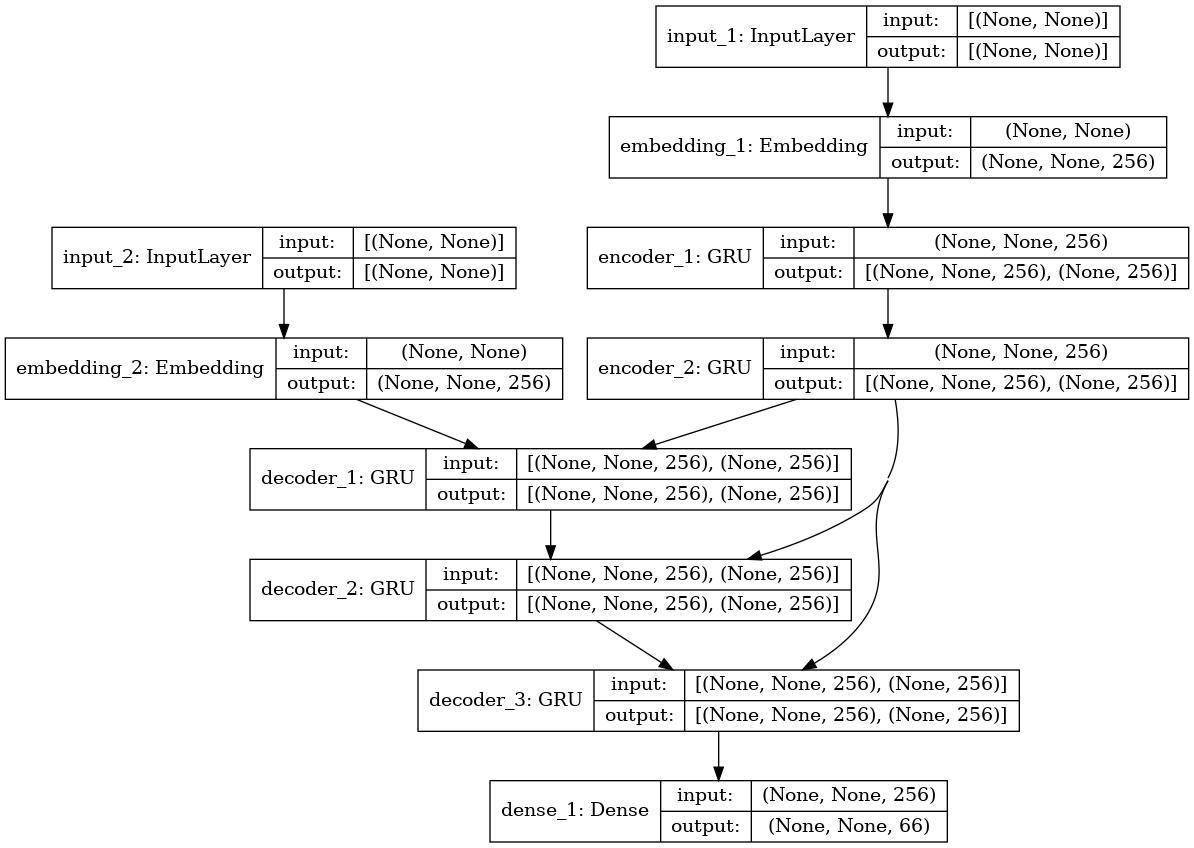

In [19]:
test1_acc, test1_exact_K_acc, test1_exact_acc, test1_loss, \
    test1_true_out, test1_pred_out, test1_pred_scores, model1 = test_model(
        '4yddq792',
        test_enc_input,
        test_dec_target,
        max_target_seq_length,
        target_char_to_int,
        target_int_to_char,
        False
    )

random_samples = print_samples(
    test_in,
    test1_true_out,
    test1_pred_out,
    test1_pred_scores
)

print(random_samples)

plot_model(model1, show_shapes=True)